# Planejamento da solução (IOT)

# Input - Entrada 

## O problema de negócio

 1. Mapear as previsões de escolha de destino aos usuários de uma plataforma de locação de hospedagem.

# Output - Saída

## Modelo de Previsão para escolha do primeiro destino do usuário.


   1.0. Predições serão salvas em uma tabela do banco de dados.

   2.0. API

   Input: usuários e suas características;

   Output: usuários e suas características com a predição do destino;

# Tasks - Processo

 * New York City Airbnb Open Data:
 * https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data/code
 * Airbnb listings and metrics in NYC, NY, USA (2019)
    

*- Compreensão do modelo de negócio do Airbnb*
   - Marketplace ( Conectar pessoas que oferecem acomodação, com pessoas que estão procurando acomodação).
 
    
*- Usuários oferecem acomodações*
   - Tamanho do portfólio.
   - Diversidade/Densidade de Portfólio.
   - Preço Médio

*- Alta demanda* (usuário que não desejam hotel).
   - Número de Usuários
   - LTV ( Lifetime Value )
   - CAC ( Client Acquisition Cost )
   - Gross Revenue = ( Fee*Número cliente ) - CAC 

# 0.0. Imports

In [32]:
import random
import numpy   as np
import pandas  as pd
import seaborn as sns


from sklearn               import model_selection as ms
from sklearn               import preprocessing   as pp
from sklearn               import metrics         as m
from scikitplot            import metrics         as mt
from scipy                 import stats           as ss
from matplotlib            import pyplot          as plt
from IPython.core.display  import HTML

from keras import models as ml
from keras import layers as l

## 0.1. Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [35]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/ehgeraldo/miniconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Loading Data

In [4]:
pwd

'/home/ehgeraldo/repos/airbnb'

In [55]:
# train load data
df_raw = pd.read_csv('/home/ehgeraldo/repos/airbnb/data/train_users.csv')

# sessions load data
df_sessions = pd.read_csv('/home/ehgeraldo/repos/airbnb/data/sessions.csv')

In [6]:
# UserDataset
df_raw.shape

(213451, 16)

In [52]:
# UserDataset (granularity)
df_raw.head(2)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF


In [54]:
# SessionsDataset
df_sessions.shape

(9213930, 6)

In [53]:
# SessionsDataset (granularity)
df_sessions.head(2)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0


# 1.0. Data Description

In [8]:
df1 = df_raw.copy()

## 1.1. Data Dimension

In [47]:
print( 'Number of rows:    {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows:    67784
Number of columns: 16


In [48]:
print( 'Number of rows:    {}'.format( df_sessions.shape[0] ) )
print( 'Number of columns: {}'.format( df_sessions.shape[1] ) )

Number of rows:    9213930
Number of columns: 6


## 1.2. Data Type

In [11]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [49]:
df1.sample().T

,172664
id,f4leg83w09
date_account_created,2014-04-07 00:00:00
timestamp_first_active,2014-04-07 06:42:04
date_first_booking,2014-04-15 00:00:00
gender,-unknown-
age,36
signup_method,basic
signup_flow,0
language,en
affiliate_channel,direct


In [12]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

In [50]:
df_sessions.sample().T

,1986409
user_id,8w236a1unv
action,search_results
action_type,click
action_detail,view_search_results
device_type,Mac Desktop
secs_elapsed,6838.0


## 1.3. NA Check

In [13]:
df1.isna().sum() / len( df1 )

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [14]:
df_sessions.isna().sum() / len( df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

### Replace NAs

In [15]:
df1 = df1.dropna()
df1.shape

(68171, 16)

In [45]:
# df1(NA drop) / df_raw(with NA)

print('Removed data: {:.2f}%'.format( 1-(df1.shape[0] / df_raw.shape[0] ) ) )

Removed data: 0.68%


In [56]:
df_sessions_dropna = df_sessions.dropna()
df_sessions_dropna.shape

(9213930, 6)

In [57]:
# dfsessions_dropna(NA drop) / dfsessions(with NA)

print('Removed data: {:.2f}%'.format( 1-(df_sessions_dropna.shape[0] / df_sessions.shape[0] ) ) )

Removed data: 0.13%


In [19]:
# remove missing value completly
#df1 = df1.dropna()

# ========== User =================
# date_first_booking
date_first_booking_max = pd.to_datetime( df1['date_first_booking'] ).max().strftime( '%Y-%m-%d' )
df1['date_first_booking'] = df1['date_first_booking'].fillna( date_first_booking_max )

# age
df1 = df1[( df1['age'] > 15 ) & ( df1['age'] < 120 )]
avg_age = df1['age'].mean().astype( int )
df1['age'] = df1['age'].fillna( avg_age )

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ========== Sessions =================
# user_id - 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]

# action_type - 11%
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_detail - 11%
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

In [20]:
df1.isna().sum() / len( df1 )

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [21]:
df_sessions.isna().sum() / len( df_sessions)

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.4. Change Data Type

In [22]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [23]:
# date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( int )

## 1.5. Check Balanced Data

In [24]:
df1['country_destination'].value_counts( normalize=True )

US       0.708973
other    0.110808
FR       0.054128
IT       0.029712
GB       0.025935
ES       0.024858
CA       0.015697
DE       0.012407
NL       0.008778
AU       0.006388
PT       0.002316
Name: country_destination, dtype: float64

## 1.6. Descriptive Analysis

In [25]:
# Users
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

# Sessions
num_attributes_sessions = df_sessions.select_dtypes( include=['int64', 'float64'] )
cat_attributes_sessions = df_sessions.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes_sessions = df_sessions.select_dtypes( include=['datetime64[ns]'] )

### 1.6.1. Numerical - Users

In [26]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.091393,33.0,13.745314,2.239393,7.314452
1,signup_flow,0.0,25.0,25.0,2.439529,0.0,6.538692,2.804384,6.422765


/home/ehgeraldo/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ehgeraldo/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

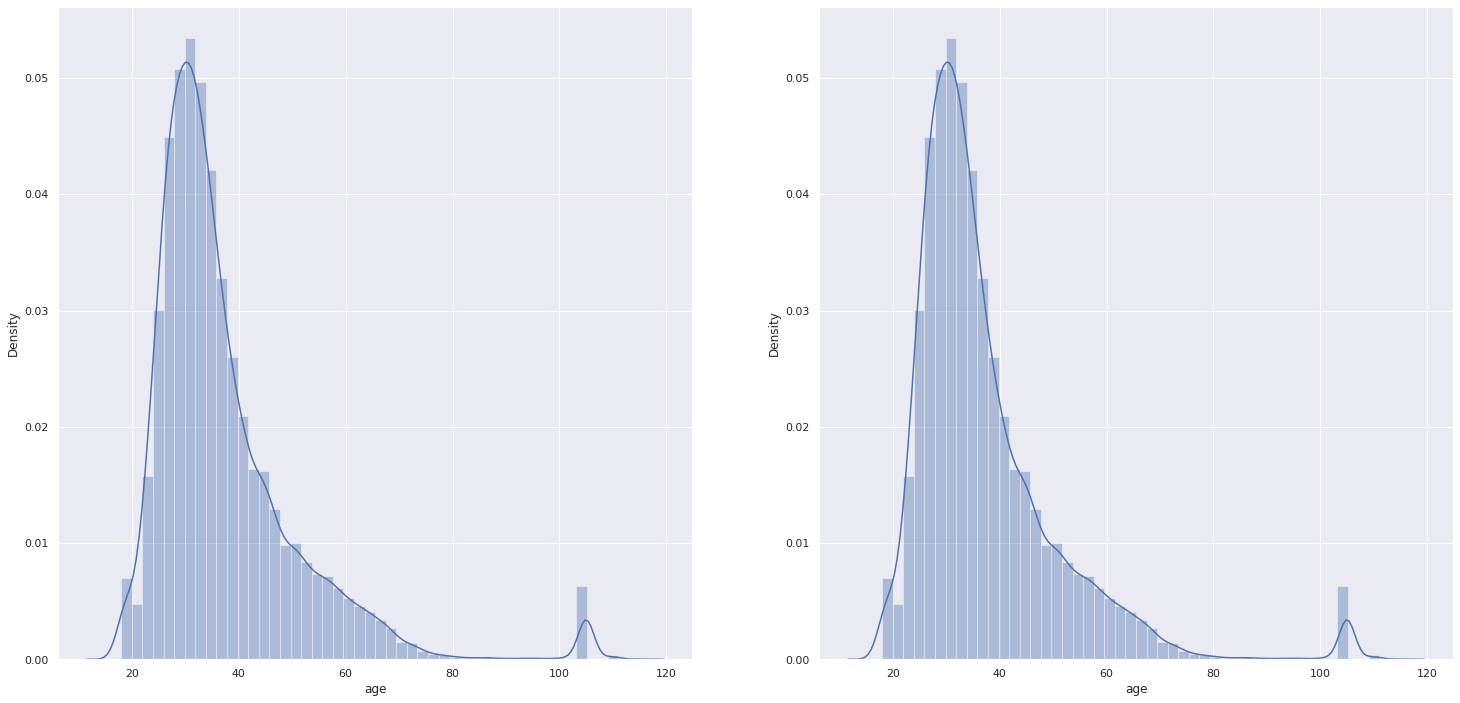

In [36]:
# Age attribute dispersion

plt.subplot( 1, 2, 1 )
sns.distplot( df1['age'] )

plt.subplot( 1, 2, 2 ) 
sns.distplot( df1[ df1[ 'age' ] < 120 ] ['age'] )

### 1.6.2. Numerical - Sessions

In [27]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame( num_attributes_sessions.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes_sessions.apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes_sessions.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes_sessions.apply( min ) ).T
d3 = pd.DataFrame( num_attributes_sessions.apply( max ) ).T
d4 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.6.3. Categorial - Users

In [28]:
cat_attributes.drop( 'id', axis=1 ).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,67784,67784,67784,67784,67784,67784,67784,67784,67784,67784
unique,4,3,23,8,16,7,4,9,36,11
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
freq,29641,44614,66051,45533,45437,37298,60685,33749,24094,48057


### 1.6.4. Categorial - Sesssions

In [29]:
cat_attributes_sessions.drop( 'user_id', axis=1 ).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


### 1.6.5. Categorial - Sessions

In [30]:
cat_attributes_list = cat_attributes_sessions.drop( 'user_id', axis=1 ).columns.tolist()

corr_dict = {}
for i in range( len ( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v( cat_attributes_sessions[ ref ], cat_attributes_sessions[ feat ] )
        
        # append a list
        corr_list.append( corr )
    
    # appende a correlation list for each ref attributs
    corr_dict[ ref ] = corr_list

<AxesSubplot:>

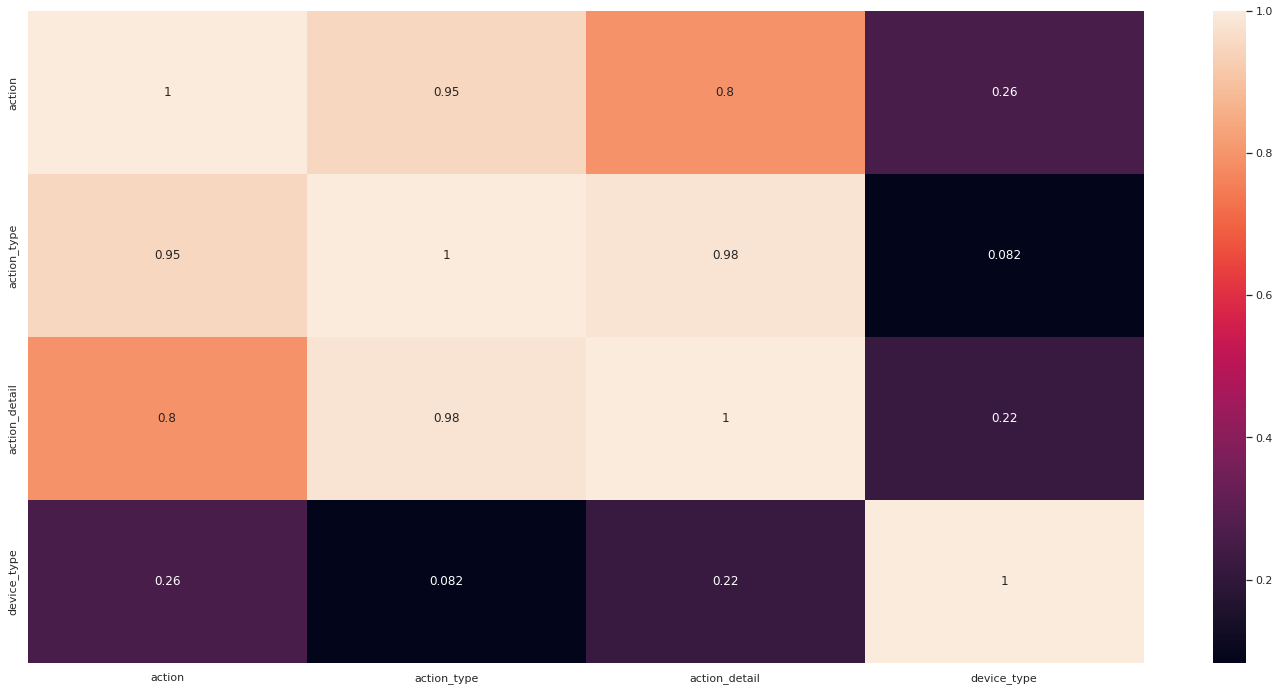

In [37]:
d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns)
sns.heatmap( d, annot=True )

### 1.6.6 Confusion Matrix analysis

* Action and Action_Type - 0,95 - 95% correlated; and action has 359 features
* Action_type and action_detail - 0,98 - 98% correlated; and action_detail has 155 features

# 2.0. Data Filtering

In [25]:
df2 = df1.copy()

## 2.1. Filtering Rows

In [26]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are few people over 12O year old   
df2 = df2[( df2['age'] > 15 ) & ( df2['age'] < 120 )]

# secs_elapsed - there is no possible 0 secs elapsed on website
#df2 = df2[df2['secs_elapsed'] > 0]

## 2.2. Columns Selection

# 3.0. Data Preparation

In [27]:
df3 = df2.copy()

In [28]:
# dummy variable
df3_dummy = pd.get_dummies( df3.drop( ['id', 'country_destination'], axis=1 ) )

# join id and country destination
df3 = pd.concat( [df3[['id', 'country_destination']], df3_dummy], axis=1 )

In [29]:
df3.shape

(122636, 125)

# 4.0. Feature Selection

In [31]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking'] # original dates
df4 = df3.drop( cols_drop, axis=1 )

In [32]:
X = df4.drop( 'country_destination', axis=1 )
y = df4['country_destination'].copy()

In [33]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 )

# 5.0. Machine Learning Model

In [34]:
x_train = X_train.drop( 'id', axis=1 )
x_test =  X_test.drop(  'id', axis=1 )

## 5.1. Baseline Model

In [35]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()

k_num = y_test.shape[0]

country_destination_weights = df1['country_destination'].value_counts( normalize=True ).sort_index().tolist()

yhat_random = random.choices( population=country_destination_list,weights=country_destination_weights,k=k_num )

### 5.1. Baseline Model Performance

Accuracy: 0.35543052837573386
Balanced Accuracy:0.080003538573245
Kappa Score: -0.0054367569742197475
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        87
          CA       0.01      0.01      0.01       216
          DE       0.00      0.00      0.00       164
          ES       0.01      0.01      0.01       319
          FR       0.04      0.04      0.04       736
          GB       0.01      0.01      0.01       361
          IT       0.01      0.01      0.01       420
         NDF       0.44      0.44      0.44     10962
          NL       0.00      0.00      0.00       105
          PT       0.00      0.00      0.00        31
          US       0.39      0.39      0.39      9606
       other       0.06      0.06      0.06      1521

    accuracy                           0.36     24528
   macro avg       0.08      0.08      0.08     24528
weighted avg       0.36      0.36      0.36     24528



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

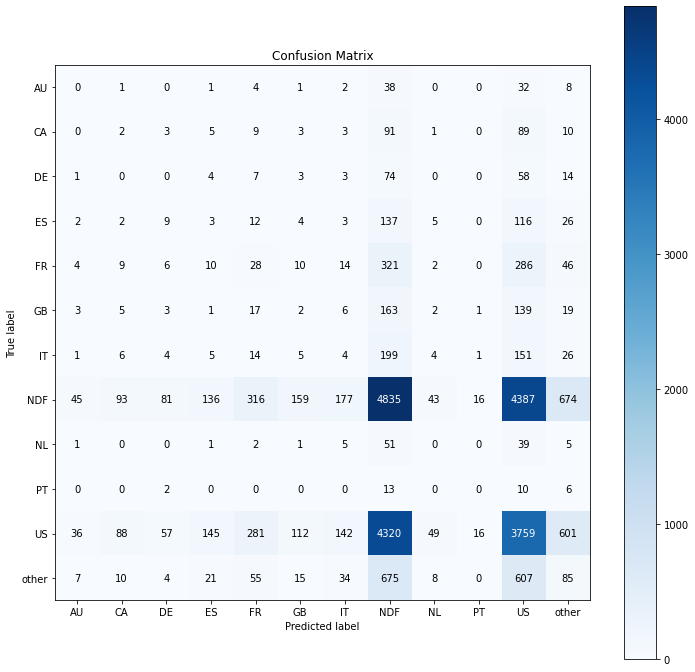

In [36]:
# Accuracy
acc_random = m.accuracy_score( y_test, yhat_random )
print( 'Accuracy: {}'.format( acc_random ) )

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score( y_test, yhat_random )
print( 'Balanced Accuracy:{}'.format( balanced_acc_random ) )

# Kappa Metrics
kappa_random = m.cohen_kappa_score( y_test, yhat_random )
print( 'Kappa Score: {}'.format( kappa_random ) )

# Classification report
print( m.classification_report( y_test, yhat_random ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12,12))

## 5.2. Neural Network - MLP

In [37]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [38]:
x_train.shape

(98108, 120)

In [39]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
model.add( l.Dense( 12, activation='softmax') )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

Epoch 1/100
3066/3066 [==============================] - 2s 602us/step - loss: 1.3013 - accuracy: 0.5229
Epoch 2/100
3066/3066 [==============================] - 2s 581us/step - loss: 1.2761 - accuracy: 0.5304
Epoch 3/100
3066/3066 [==============================] - 2s 576us/step - loss: 1.2708 - accuracy: 0.5324
Epoch 4/100
3066/3066 [==============================] - 2s 589us/step - loss: 1.2680 - accuracy: 0.5321
Epoch 5/100
3066/3066 [==============================] - 2s 596us/step - loss: 1.2660 - accuracy: 0.5334
Epoch 6/100
3066/3066 [==============================] - 2s 572us/step - loss: 1.2644 - accuracy: 0.5343
Epoch 7/100
3066/3066 [==============================] - 2s 574us/step - loss: 1.2632 - accuracy: 0.5351
Epoch 8/100
3066/3066 [==============================] - 2s 595us/step - loss: 1.2625 - accuracy: 0.5360
Epoch 9/100
3066/3066 [==============================] - 2s 565us/step - loss: 1.2613 - accuracy: 0.5367
Epoch 10/100
3066/3066 [==============================]

Epoch 78/100
3066/3066 [==============================] - 2s 695us/step - loss: 1.2361 - accuracy: 0.5418
Epoch 79/100
3066/3066 [==============================] - 2s 732us/step - loss: 1.2356 - accuracy: 0.5425
Epoch 80/100
3066/3066 [==============================] - 2s 653us/step - loss: 1.2360 - accuracy: 0.5417
Epoch 81/100
3066/3066 [==============================] - 2s 579us/step - loss: 1.2352 - accuracy: 0.5415
Epoch 82/100
3066/3066 [==============================] - 2s 699us/step - loss: 1.2354 - accuracy: 0.5430
Epoch 83/100
3066/3066 [==============================] - 2s 732us/step - loss: 1.2351 - accuracy: 0.5421
Epoch 84/100
3066/3066 [==============================] - 2s 577us/step - loss: 1.2350 - accuracy: 0.5431
Epoch 85/100
3066/3066 [==============================] - 2s 564us/step - loss: 1.2350 - accuracy: 0.5422
Epoch 86/100
3066/3066 [==============================] - 2s 582us/step - loss: 1.2344 - accuracy: 0.5432
Epoch 87/100
3066/3066 [======================

### 5.2.1. NN Performance

In [40]:
# prediction
pred_nn = model.predict( x_test )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn )

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]

Accuracy: 0.5328196347031964
Balanced Accuracy:0.10677649948352334
Kappa Score: 0.19813801275787624


/Users/meigarom.lopes/.pyenv/versions/3.8.0/envs/airbnbpredictfirstbooking/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        87
          CA       0.00      0.00      0.00       216
          DE       0.33      0.01      0.01       164
          ES       0.25      0.00      0.01       319
          FR       0.00      0.00      0.00       736
          GB       0.00      0.00      0.00       361
          IT       0.00      0.00      0.00       420
         NDF       0.58      0.62      0.60     10962
          NL       0.00      0.00      0.00       105
          PT       0.00      0.00      0.00        31
          US       0.49      0.65      0.56      9606
       other       0.00      0.00      0.00      1521

    accuracy                           0.53     24528
   macro avg       0.14      0.11      0.10     24528
weighted avg       0.46      0.53      0.49     24528



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

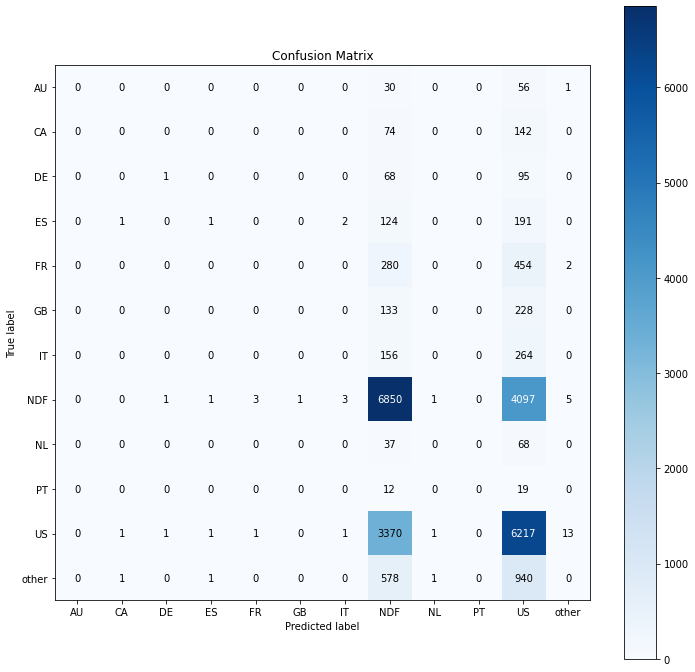

In [41]:
# Accuracy
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print( 'Accuracy: {}'.format( acc_nn ) )

# Balanced Accuray
balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
print( 'Balanced Accuracy:{}'.format( balanced_acc_nn ) )

# Kappa Metrics
kappa_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
print( 'Kappa Score: {}'.format( kappa_nn ) )

# Classification report
print( m.classification_report( y_test_nn, yhat_nn ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12))

### 5.2.3. NN Performance - Cross-Validation

In [ ]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
    model.add( l.Dense( 11, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

In [ ]:
print( 'Avg Balanced Accuracy: {} +/- {}'.format( np.mean( balanced_acc_list ), np.std( balanced_acc_list ) )
print( 'Avg Kappa: {} +/- {}'.format( np.mean( kappa_acc_list ), np.std( kappa_acc_list ) )